In [1]:
from neuron import h
import numpy as np
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc')
T=3055
simdur =3*T

def performance(gsyn12, gsyn21, gfb12, gfb21):
    sec = h.Section(name='mod')
    sec.insert('brainb')
    sec.insert('bodyb')
    seg = sec(0.5)

    seg.brainb.gsyn12 = gsyn12
    seg.brainb.gsyn21 = gsyn21
    seg.brainb.gfb12 = gfb12
    seg.brainb.gfb21 = gfb21

   
    seg.brainb._ref_L1Pointer = seg.bodyb._ref_L1
    seg.brainb._ref_L2Pointer = seg.bodyb._ref_L2
    seg.bodyb._ref_V1Pointer = seg.brainb._ref_V1
    seg.bodyb._ref_V2Pointer = seg.brainb._ref_V2


    Qv = h.Vector().record(seg.bodyb._ref_Q)
    tv = h.Vector().record(h._ref_t)

    # Simulate
    h.finitialize()
    h.cvode.active(1)
    h.continuerun(simdur)

    Q = np.array(Qv)
    return Q[-1] / simdur  


original_gsyn12=0.005
original_gsyn21=0.005
original_gfb12=0.001
original_gfb21=0.001
original_perf = performance(original_gsyn12, original_gsyn21, original_gfb12, original_gfb21)
print(f"Baseline performance (symmetric): {original_perf:.6e}")



Baseline performance (symmetric): 1.230801e-03


In [2]:
gsyn12_vals = np.linspace(0.0005, 0.03, 20)
perf_gsyn12 = [performance(g, original_gsyn21, original_gfb12, original_gfb21) for g in gsyn12_vals]
opt_gsyn12 = gsyn12_vals[np.argmax(perf_gsyn12)]
print(f"Optimal gsyn12 = {opt_gsyn12:.6f}, Perf = {max(perf_gsyn12):.6e}")
gsyn21_vals = np.linspace(0.0006, 0.03, 20)
perf_gsyn21 = [performance(original_gsyn21,g, original_gfb12, original_gfb21) for g in gsyn21_vals]
opt_gsyn21 = gsyn21_vals[np.argmax(perf_gsyn21)]
print(f" Optimal gsyn21 = {opt_gsyn21:.6f}, Perf = {max(perf_gsyn21):.6e}")

Optimal gsyn12 = 0.003605, Perf = 1.382516e-03
 Optimal gsyn21 = 0.002147, Perf = 1.388027e-03


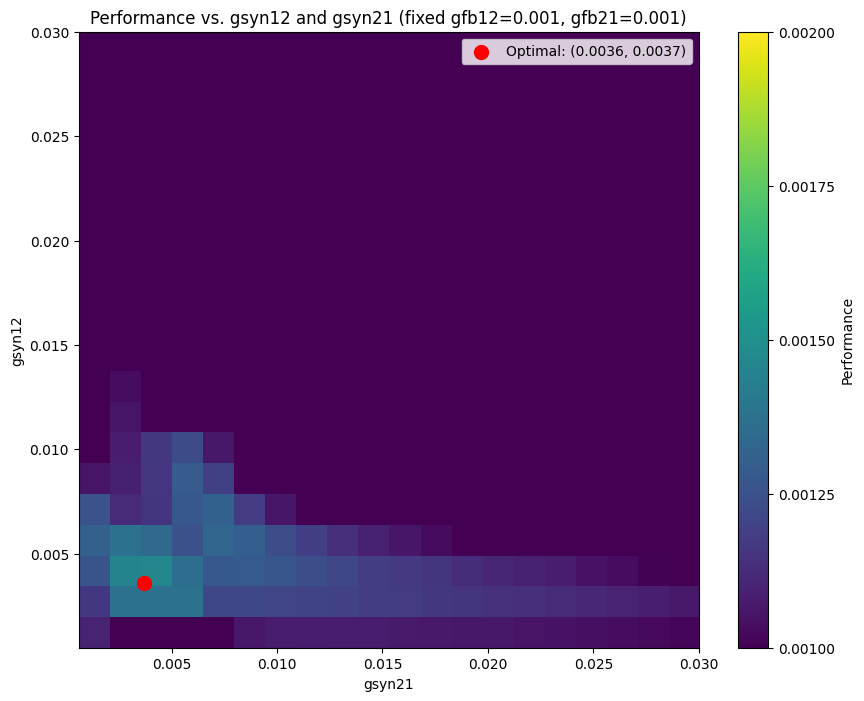

In [3]:
# 2D optimization of gsyn12 and gsyn21
performance_grid = np.zeros((len(gsyn12_vals), len(gsyn21_vals)))

for i, gs12 in enumerate(gsyn12_vals):
    for j, gs21 in enumerate(gsyn21_vals):
        performance_grid[i, j] = performance(gs12, gs21, original_gfb12, original_gfb21)

max_perf = np.max(performance_grid)
opt_idx = np.unravel_index(np.argmax(performance_grid), performance_grid.shape)
opt_gsyn12 = gsyn12_vals[opt_idx[0]]
opt_gsyn21 = gsyn21_vals[opt_idx[1]]

plt.figure(figsize=(10, 8))
im = plt.imshow(performance_grid, 
               extent=[gsyn21_vals.min(), gsyn21_vals.max(), gsyn12_vals.min(), gsyn12_vals.max()],
               origin='lower', cmap='viridis', aspect='auto',
               vmin=1e-3, vmax=2e-3)  # Explicit color limits
plt.scatter(opt_gsyn21, opt_gsyn12, color='red', s=100, 
            label=f'Optimal: ({opt_gsyn12:.4f}, {opt_gsyn21:.4f})')
cbar = plt.colorbar(im, label='Performance')
cbar.set_ticks(np.linspace(1e-3, 2e-3, 5))  

plt.xlabel('gsyn21')
plt.ylabel('gsyn12')
plt.title('Performance vs. gsyn12 and gsyn21 (fixed gfb12=0.001, gfb21=0.001)')
plt.legend()
plt.show()

In [4]:

gfb12_vals = np.linspace(0.0001, 0.05, 20)
perf_gfb12 = [performance(original_gsyn12, original_gsyn21, g, original_gfb21) for g in gfb12_vals]
opt_gfb12 = gfb12_vals[np.argmax(perf_gfb12)]
print(f"Best gfb12 = {opt_gfb12:.6f}, Perf = {max(perf_gfb12):.6e}")

gfb21_vals = np.linspace(0.0006, 0.05, 20)
perf_gfb21 = [performance(original_gsyn12, original_gsyn21, original_gfb12, g) for g in gfb21_vals]
opt_gfb21 = gfb21_vals[np.argmax(perf_gfb21)]
print(f"Best gfb21 = {opt_gfb21:.6f}, Perf = {max(perf_gfb21):.6e}")


Best gfb12 = 0.000100, Perf = 1.394214e-03
Best gfb21 = 0.003200, Perf = 1.324108e-03


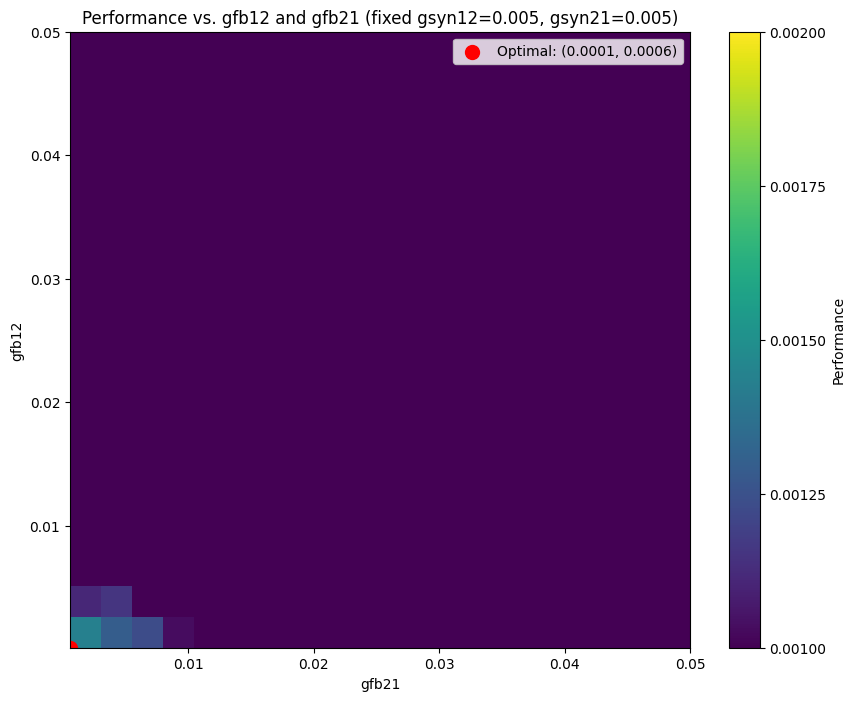

In [5]:

performance_grid = np.zeros((len(gfb12_vals), len(gfb21_vals)))

for i, gf12 in enumerate(gfb12_vals):
    for j, gf21 in enumerate(gfb21_vals):
        performance_grid[i, j] = performance(original_gsyn12, original_gsyn21, gf12, gf21)

max_perf = np.max(performance_grid)
opt_idx = np.unravel_index(np.argmax(performance_grid), performance_grid.shape)
opt_gfb12 = gfb12_vals[opt_idx[0]]
opt_gfb21 = gfb21_vals[opt_idx[1]]

plt.figure(figsize=(10, 8))
im = plt.imshow(performance_grid, 
               extent=[gfb21_vals.min(), gfb21_vals.max(), gfb12_vals.min(), gfb12_vals.max()],
               origin='lower', cmap='viridis', aspect='auto',
               vmin=1e-3, vmax=2e-3) 

plt.scatter(opt_gfb21, opt_gfb12, color='red', s=100, 
           label=f'Optimal: ({opt_gfb12:.4f}, {opt_gfb21:.4f})')

cbar = plt.colorbar(im, label='Performance')
cbar.set_ticks(np.linspace(1e-3, 2e-3, 5))  
plt.xlabel('gfb21')
plt.ylabel('gfb12')
plt.title('Performance vs. gfb12 and gfb21 (fixed gsyn12=0.005, gsyn21=0.005)')
plt.legend()
plt.show()

In [6]:

gsyn12_range = np.linspace(opt_gsyn12 * 0.7, opt_gsyn12 * 1.5, 5)
gsyn21_range = np.linspace(opt_gsyn21 * 0.8, opt_gsyn21 * 1.2, 5)
gfb12_range = np.linspace(opt_gfb12 * 0.6, opt_gfb12 * 1.4, 5)
gfb21_range = np.linspace(opt_gfb21 * 0.75, opt_gfb21 * 1.3, 5)

best_perf = -np.inf
best_params = (0, 0, 0, 0)

for gs12 in gsyn12_range:
    for gs21 in gsyn21_range:
        for gf12 in gfb12_range:
            for gf21 in gfb21_range:
                current_perf = performance(gs12, gs21, gf12, gf21)
                if current_perf > best_perf:
                    best_perf = current_perf
                    best_params = (gs12, gs21, gf12, gf21)
                print(f"gs12={gs12:.4f}, gs21={gs21:.4f}, gf12={gf12:.4f}, gf21={gf21:.4f}, Perf={current_perf:.4e}")

print(f"\n Optimal parameters: gsyn12={best_params[0]:.6f}, gsyn21={best_params[1]:.6f}, gfb12={best_params[2]:.6f}, gfb21={best_params[3]:.6f}")
print(f" Best performance: {best_perf:.6e}")
change = ((best_perf - original_perf) / original_perf )* 100
print(f" Change in performance: {change:.2f}%")

gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0004, Perf=1.3429e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0005, Perf=1.3509e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0006, Perf=1.3576e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0007, Perf=1.3684e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0008, Perf=1.3778e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0004, Perf=1.3410e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0005, Perf=1.3501e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0006, Perf=1.3582e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0007, Perf=1.3678e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0008, Perf=1.3767e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0004, Perf=1.3392e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0005, Perf=1.3496e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0006, Perf=1.3596e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0007, Perf=1.3681e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.00

Changed dt
Changed dt


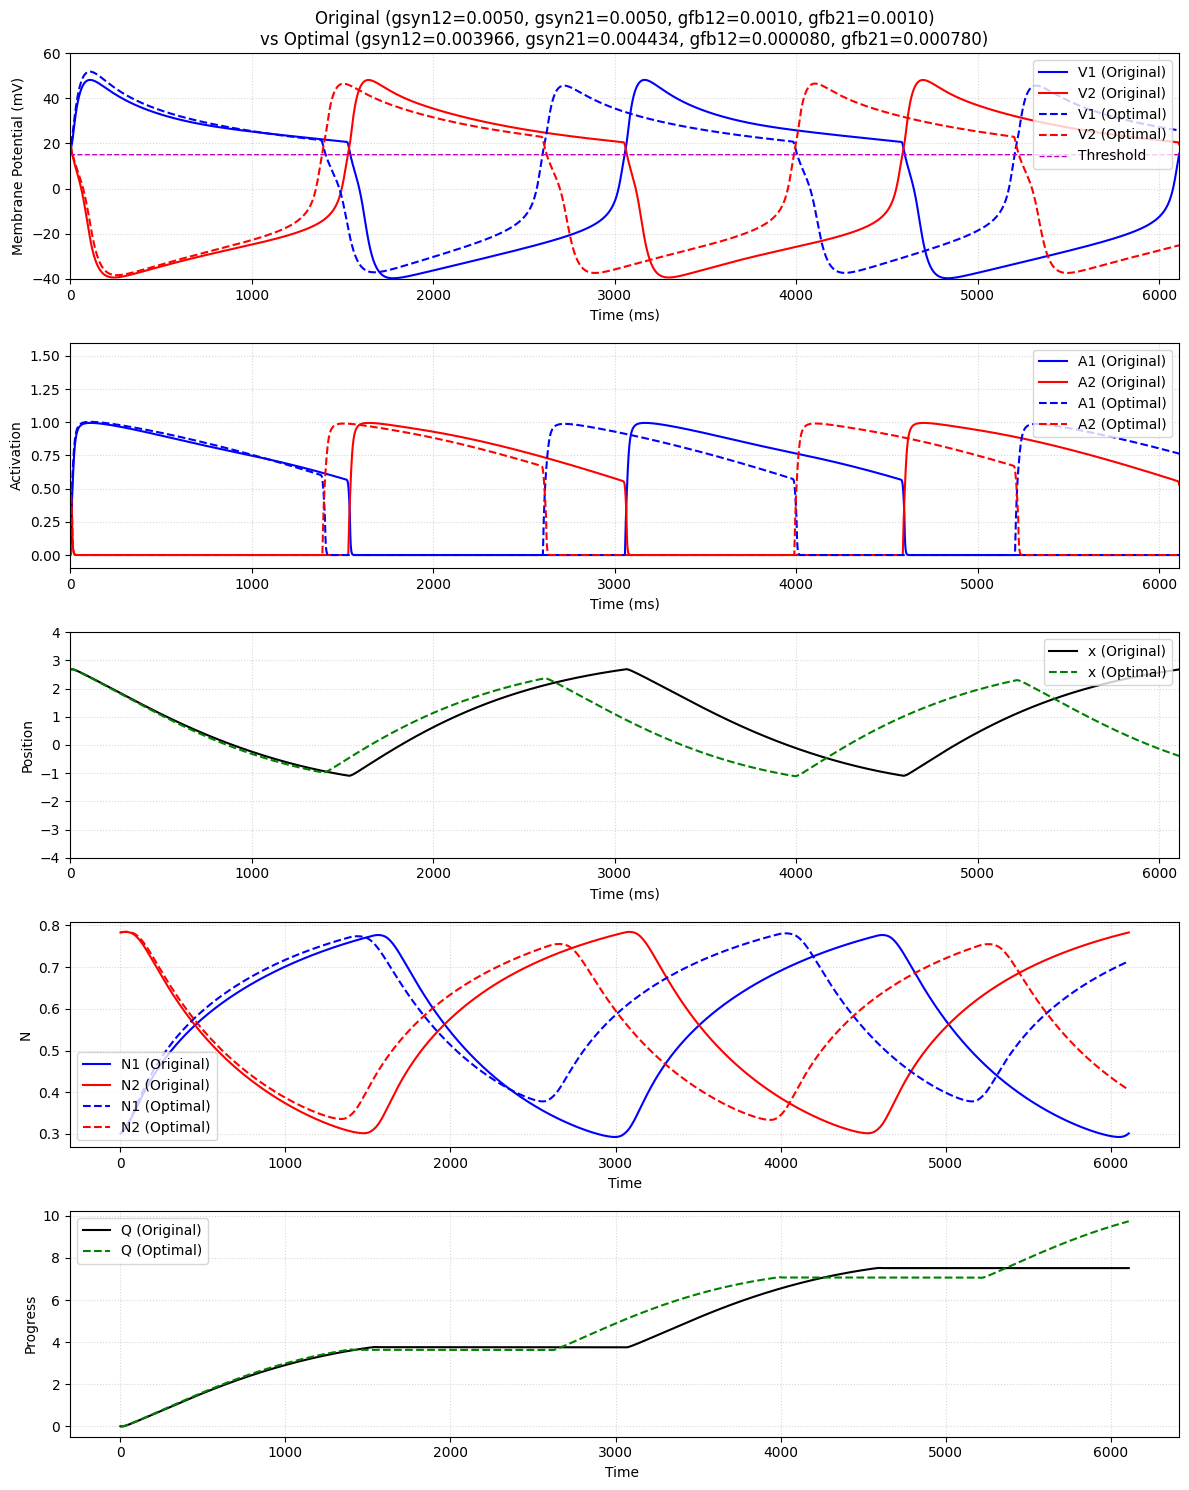

In [ ]:
def solution(gsyn12, gsyn21, gfb12, gfb21, label):
    model = h.Section(name='model')
    model.insert('brainb')
    model.insert('bodyb')
    seg = model(0.5)

    seg.brainb.gsyn12 = gsyn12
    seg.brainb.gsyn21 = gsyn21
    seg.brainb.gfb12 = gfb12
    seg.brainb.gfb21 = gfb21
    
 
    seg.brainb._ref_L1Pointer = seg.bodyb._ref_L1
    seg.brainb._ref_L2Pointer = seg.bodyb._ref_L2
    seg.bodyb._ref_V1Pointer = seg.brainb._ref_V1
    seg.bodyb._ref_V2Pointer = seg.brainb._ref_V2

    results = {
        'N1': h.Vector(),
        'N2': h.Vector(),
        'V1': h.Vector(),
        'V2': h.Vector(),
        'A1': h.Vector(),
        'A2': h.Vector(),
        'x': h.Vector(),
        'Q': h.Vector(),
        't': h.Vector(),
        'label': label
    }
    
    #  recording
    results['N1'].record(seg.brainb._ref_N1)
    results['N2'].record(seg.brainb._ref_N2)
    results['V1'].record(seg.brainb._ref_V1)
    results['V2'].record(seg.brainb._ref_V2)
    results['A1'].record(seg.bodyb._ref_A1)
    results['A2'].record(seg.bodyb._ref_A2)
    results['x'].record(seg.bodyb._ref_x)
    results['Q'].record(seg.bodyb._ref_Q)
    results['t'].record(h._ref_t)


    h.load_file('stdrun.hoc')
    h.init()
    h.cvode.active(0)  # Using fixed time step
    h.dt = 0.1        
    h.tstop = 2*T
    h.run()
    
    # Convert to numpy arrays
    for key in results:
        if key != 'label':
            results[key] = np.array(results[key])
    
    return results

# Run simulations
original_results = solution(original_gsyn12, original_gsyn21,  original_gfb12, original_gfb21, "Original")
optimal_results = solution(best_params[0], best_params[1],best_params[2], best_params[3],"Optimal")


plt.figure(figsize=(12, 15))


ax1 = plt.subplot(511)
ax1.plot(original_results['t'], original_results['V1'], 'b-', label=f'V1 ({original_results["label"]})')
ax1.plot(original_results['t'], original_results['V2'], 'r-', label=f'V2 ({original_results["label"]})')
ax1.plot(optimal_results['t'], optimal_results['V1'], 'b--', linewidth=1.5, label=f'V1 ({optimal_results["label"]})')
ax1.plot(optimal_results['t'], optimal_results['V2'], 'r--', linewidth=1.5, label=f'V2 ({optimal_results["label"]})')
ax1.plot(optimal_results['t'], 15*np.ones(len(optimal_results['t'])), '--m', linewidth=1, label='Threshold')
ax1.set_xlim(0, h.tstop)
ax1.set_ylim(-40, 60)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Membrane Potential (mV)')
ax1.legend(loc='upper right')
ax1.set_title(f'Original (gsyn12={original_gsyn12:.4f}, gsyn21={original_gsyn21:.4f}, gfb12={original_gfb12:.4f}, gfb21={original_gfb21:.4f})\n'
              f'vs Optimal (gsyn12={best_params[0]:.6f}, gsyn21={best_params[1]:.6f}, gfb12={best_params[2]:.6f}, gfb21={best_params[3]:.6f})')
ax1.grid(True, linestyle=':', alpha=0.5)


ax2 = plt.subplot(512)
ax2.plot(original_results['t'], original_results['A1'], 'b-', label=f'A1 ({original_results["label"]})')
ax2.plot(original_results['t'], original_results['A2'], 'r-', label=f'A2 ({original_results["label"]})')
ax2.plot(optimal_results['t'], optimal_results['A1'], 'b--', linewidth=1.5, label=f'A1 ({optimal_results["label"]})')
ax2.plot(optimal_results['t'], optimal_results['A2'], 'r--', linewidth=1.5, label=f'A2 ({optimal_results["label"]})')
ax2.set_xlim(0, h.tstop)
ax2.set_ylim(-0.1, 1.6)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Activation')
ax2.legend(loc='upper right')
ax2.grid(True, linestyle=':', alpha=0.5)


ax3 = plt.subplot(513)
ax3.plot(original_results['t'], original_results['x'], 'k-', label=f'x ({original_results["label"]})')
ax3.plot(optimal_results['t'], optimal_results['x'], 'g--', linewidth=1.5, label=f'x ({optimal_results["label"]})')
ax3.set_xlim(0, h.tstop)
ax3.set_ylim(-4, 4)
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Position')
ax3.legend(loc='upper right')
ax3.grid(True, linestyle=':', alpha=0.5)


ax4 = plt.subplot(514)
ax4.plot(original_results['t'], original_results['N1'], 'b-', label=f'N1 ({original_results["label"]})')
ax4.plot(original_results['t'], original_results['N2'], 'r-', label=f'N2 ({original_results["label"]})')
ax4.plot(optimal_results['t'], optimal_results['N1'], 'b--', linewidth=1.5, label=f'N1 ({optimal_results["label"]})')
ax4.plot(optimal_results['t'], optimal_results['N2'], 'r--', linewidth=1.5, label=f'N2 ({optimal_results["label"]})')
ax4.set_xlabel('Time')
ax4.set_ylabel('N')
ax4.legend()
ax4.grid(True, linestyle=':', alpha=0.5)


ax5 = plt.subplot(515)
ax5.plot(original_results['t'], original_results['Q'], 'k-', label=f'Q ({original_results["label"]})')
ax5.plot(optimal_results['t'], optimal_results['Q'], 'g--', linewidth=1.5, label=f'Q ({optimal_results["label"]})')
ax5.set_xlabel('Time ')
ax5.set_ylabel('Progress')
ax5.legend()
ax5.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()